In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# import seaborn as sns
import librosa
import noisereduce as nr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


# 忽略警告訊息（可選）
import warnings
warnings.filterwarnings('ignore')

c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = 'C:/Users/bymin/OneDrive/桌面/swallow/data/'  # 請將此替換為您的實際路徑

FEATURE_SAVE_PATH = 'C:/Users/bymin/OneDrive/桌面/swallow/feature'  # 請將此替換為您的實際路徑

# 音頻取樣率
SAMPLE_RATE = 16000

# 梅爾頻譜圖參數
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 512

def load_audio(file_path, sample_rate=SAMPLE_RATE):
    """
    加載音頻文件
    """
    audio, sr = librosa.load(file_path, sr=sample_rate)
    return audio, sr

def normalize_audio(audio):
    """
    振幅正規化，將音頻信號調整到 [-1, 1] 範圍內
    """
    max_abs_amplitude = np.max(np.abs(audio))
    if max_abs_amplitude > 0:
        audio = audio / max_abs_amplitude
    return audio

def reduce_noise(audio, sr):
    """
    降噪處理，使用 noisereduce 庫
    """
    reduced_audio = nr.reduce_noise(y=audio, sr=sr)
    return reduced_audio

def extract_mel_spectrogram(audio, sr, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    """
    提取梅爾頻譜圖特徵
    """
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )
    # 對數壓縮
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

def standardize_features(feature):
    """
    特徵標準化，零均值單位方差
    """
    mean = np.mean(feature)
    std = np.std(feature)
    standardized_feature = (feature - mean) / std
    return standardized_feature


In [3]:
# =============================
# 準備音頻文件路徑和標籤
# =============================

# 初始化列表
file_paths = []
file_labels = []

# 遍歷資料夾，假設正類和負類分別存放在 'swallowing' 和 'non-swallowing' 資料夾中
for label in ['swallow', 'non']:
    folder_path = os.path.join(DATA_PATH, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav') or filename.endswith('.mp3'):
            file_paths.append(os.path.join(folder_path, filename))
            file_labels.append(label)

# 檢查總共的樣本數量
print(f"總共的音頻樣本數：{len(file_paths)}")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(file_labels)

# 檢查編碼後的標籤
print("原始標籤：", label_encoder.classes_)
print("編碼後的標籤：", np.unique(encoded_labels))


總共的音頻樣本數：137
原始標籤： ['non' 'swallow']
編碼後的標籤： [0 1]


In [4]:
# =============================
# 生成資料索引 DataFrame（可選）
# =============================

# data_index = pd.DataFrame({
#     'file_path': file_paths,
#     'label': file_labels
# })

# # 顯示前五行
# data_index.head()



In [5]:
# =============================
# 解析類別標籤
# =============================

# 使用 LabelEncoder 將標籤轉換為數字




In [6]:
FIXED_DURATION = 1.0 # 固定時長（秒）
FIXED_LENGTH = int(SAMPLE_RATE * FIXED_DURATION)  # 固定樣本數

# ...（準備音頻文件路徑和標籤的代碼保持不變）...

# 初始化列表
features = []
labels = []

# 遍歷音頻文件，提取特徵
for idx, (file_path, label) in enumerate(zip(file_paths, encoded_labels)):
    try:
        # 加載音頻
        audio, sr = load_audio(file_path)
        
        # 確保音頻時長一致
        if len(audio) < FIXED_LENGTH:
            # 如果音頻短於固定長度，進行零填充
            pad_width = FIXED_LENGTH - len(audio)
            audio = np.pad(audio, (0, pad_width), mode='constant')
        else:
            # 如果音頻長於固定長度，進行截斷
            audio = audio[:FIXED_LENGTH]
        # 振幅正規化
        audio = normalize_audio(audio)
        # 降噪處理
        audio = reduce_noise(audio, sr)
        # 提取梅爾頻譜圖
        feature = extract_mel_spectrogram(audio, sr)
        # 標準化特徵
        feature = standardize_features(feature)
        # 檢查特徵形狀，確保一致
        expected_shape = (N_MELS, int(np.ceil((FIXED_LENGTH - N_FFT) / HOP_LENGTH)) + 1)
        if feature.shape != expected_shape:
            # 如果形狀不一致，進行修正
            feature = librosa.util.fix_length(feature, size=expected_shape[1], axis=1)
        # 展平成一維向量
        feature = feature.flatten()
        # 添加到列表
        features.append(feature)
        labels.append(label)
        
        # 進度輸出
        if (idx + 1) % 1 == 0:
            print(f"已處理 {idx + 1} / {len(file_paths)} 個文件")
                
    except Exception as e:
        print(f"處理文件 {file_path} 時發生錯誤：{e}")

feature_shapes = [feature.shape for feature in features]
unique_shapes = set(feature_shapes)

print("特徵形狀集合：", unique_shapes)

# 確保只有一種特徵形狀
if len(unique_shapes) == 1:
    # 轉換為 NumPy 陣列
    features = np.array(features)
    labels = np.array(labels)
    
    print("特徵矩陣形狀：", features.shape)
    print("標籤向量形狀：", labels.shape)
else:
    print("特徵形狀不一致，請檢查預處理步驟。")



已處理 1 / 137 個文件
已處理 2 / 137 個文件
已處理 3 / 137 個文件
已處理 4 / 137 個文件
已處理 5 / 137 個文件
已處理 6 / 137 個文件
已處理 7 / 137 個文件
已處理 8 / 137 個文件
已處理 9 / 137 個文件
已處理 10 / 137 個文件
已處理 11 / 137 個文件
已處理 12 / 137 個文件
已處理 13 / 137 個文件
已處理 14 / 137 個文件
已處理 15 / 137 個文件
已處理 16 / 137 個文件
已處理 17 / 137 個文件
已處理 18 / 137 個文件
已處理 19 / 137 個文件
已處理 20 / 137 個文件
已處理 21 / 137 個文件
已處理 22 / 137 個文件
已處理 23 / 137 個文件
已處理 24 / 137 個文件
已處理 25 / 137 個文件
已處理 26 / 137 個文件
已處理 27 / 137 個文件
已處理 28 / 137 個文件
已處理 29 / 137 個文件
已處理 30 / 137 個文件
已處理 31 / 137 個文件
已處理 32 / 137 個文件
已處理 33 / 137 個文件
已處理 34 / 137 個文件
已處理 35 / 137 個文件
已處理 36 / 137 個文件
已處理 37 / 137 個文件
已處理 38 / 137 個文件
已處理 39 / 137 個文件
已處理 40 / 137 個文件
已處理 41 / 137 個文件
已處理 42 / 137 個文件
已處理 43 / 137 個文件
已處理 44 / 137 個文件
已處理 45 / 137 個文件
已處理 46 / 137 個文件
已處理 47 / 137 個文件
已處理 48 / 137 個文件
已處理 49 / 137 個文件
已處理 50 / 137 個文件
已處理 51 / 137 個文件
已處理 52 / 137 個文件
已處理 53 / 137 個文件
已處理 54 / 137 個文件
已處理 55 / 137 個文件
已處理 56 / 137 個文件
已處理 57 / 137 個文件
已處理 58 / 137 個文件
已處理 59 / 137 個文件
已處理 60

In [7]:
# =============================
# 將列表轉換為 NumPy 陣列
# =============================

features = np.array(features)
labels = np.array(labels)

# 檢查形狀
print("特徵矩陣形狀：", features.shape)
print("標籤向量形狀：", labels.shape)


特徵矩陣形狀： (137, 1984)
標籤向量形狀： (137,)


In [8]:
# =============================
# 劃分資料集
# =============================

# 首先劃分訓練集和臨時集（驗證集 + 測試集）
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.3, random_state=42, stratify=labels)

# 然後劃分驗證集和測試集
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 檢查各個資料集的形狀
print("訓練集特徵形狀：", X_train.shape)
print("訓練集標籤形狀：", y_train.shape)
print("驗證集特徵形狀：", X_val.shape)
print("驗證集標籤形狀：", y_val.shape)
print("測試集特徵形狀：", X_test.shape)
print("測試集標籤形狀：", y_test.shape)


訓練集特徵形狀： (95, 1984)
訓練集標籤形狀： (95,)
驗證集特徵形狀： (21, 1984)
驗證集標籤形狀： (21,)
測試集特徵形狀： (21, 1984)
測試集標籤形狀： (21,)


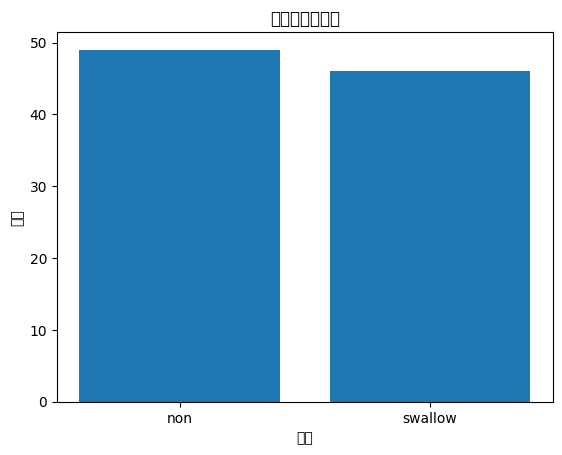

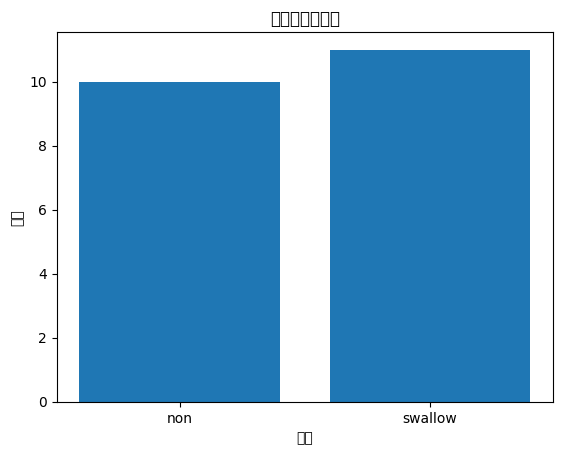

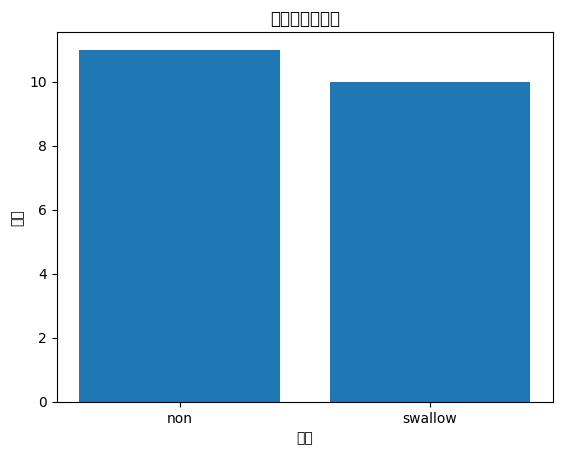

特徵和標籤已保存到指定路徑。


In [9]:
# 檢查資料平衡性
def plot_label_distribution(labels, title):
    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, tick_label=label_encoder.inverse_transform(unique))
    plt.title(title)
    plt.xlabel('類別')
    plt.ylabel('數量')
    plt.show()

# 訓練集
plot_label_distribution(y_train, '訓練集標籤分佈')
# 驗證集
plot_label_distribution(y_val, '驗證集標籤分佈')
# 測試集
plot_label_distribution(y_test, '測試集標籤分佈')

# 創建保存特徵的資料夾
if not os.path.exists(FEATURE_SAVE_PATH):
    os.makedirs(FEATURE_SAVE_PATH)

# 保存特徵和標籤
np.save(os.path.join(FEATURE_SAVE_PATH, 'X_train.npy'), X_train)
np.save(os.path.join(FEATURE_SAVE_PATH, 'y_train.npy'), y_train)
np.save(os.path.join(FEATURE_SAVE_PATH, 'X_val.npy'), X_val)
np.save(os.path.join(FEATURE_SAVE_PATH, 'y_val.npy'), y_val)
np.save(os.path.join(FEATURE_SAVE_PATH, 'X_test.npy'), X_test)
np.save(os.path.join(FEATURE_SAVE_PATH, 'y_test.npy'), y_test)

print("特徵和標籤已保存到指定路徑。")

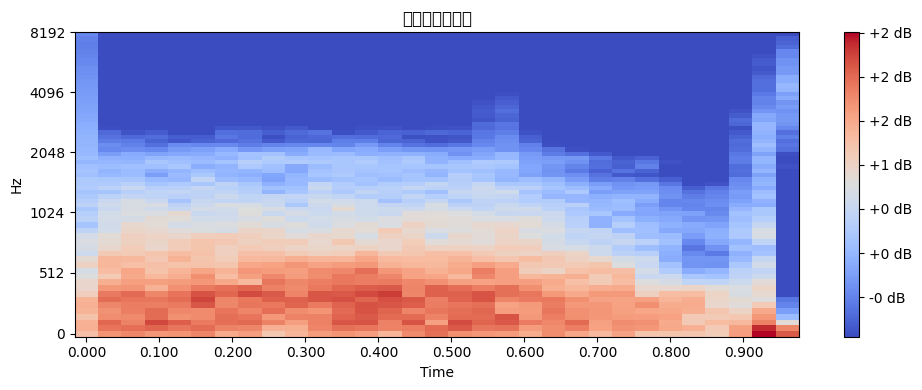

In [10]:
# 視覺化示例：顯示一個梅爾頻譜圖

# 選取一個特徵作為示例
sample_feature = X_train[8]

# 恢復為原始形狀
sample_feature = sample_feature.reshape(N_MELS, -1)

# 顯示梅爾頻譜圖
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_feature, x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
plt.colorbar(format='%+2.0f dB')
plt.title('示例梅爾頻譜圖')
plt.tight_layout()
plt.show()


In [11]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 設定隨機種子，確保實驗的可重複性
torch.manual_seed(42)
np.random.seed(42)
FEATURE_SAVE_PATH = 'feature'
X_train = np.load(os.path.join(FEATURE_SAVE_PATH, 'X_train.npy'))
y_train = np.load(os.path.join(FEATURE_SAVE_PATH, 'y_train.npy'))
X_val = np.load(os.path.join(FEATURE_SAVE_PATH, 'X_val.npy'))
y_val = np.load(os.path.join(FEATURE_SAVE_PATH, 'y_val.npy'))
X_test = np.load(os.path.join(FEATURE_SAVE_PATH, 'X_test.npy'))
y_test = np.load(os.path.join(FEATURE_SAVE_PATH, 'y_test.npy'))

# 檢查資料形狀
print("訓練集特徵形狀：", X_train.shape)
print("訓練集標籤形狀：", y_train.shape)
print("驗證集特徵形狀：", X_val.shape)
print("驗證集標籤形狀：", y_val.shape)
print("測試集特徵形狀：", X_test.shape)
print("測試集標籤形狀：", y_test.shape)

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

# 將標籤轉換為 int64（long tensor）
y_train = y_train.astype(np.int64)
y_val = y_val.astype(np.int64)
y_test = y_test.astype(np.int64)

訓練集特徵形狀： (95, 1984)
訓練集標籤形狀： (95,)
驗證集特徵形狀： (21, 1984)
驗證集標籤形狀： (21,)
測試集特徵形狀： (21, 1984)
測試集標籤形狀： (21,)


In [12]:
# 定義自訂的 Dataset

class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        return feature, label

# 創建資料集
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)
test_dataset = AudioDataset(X_test, y_test)

# 創建 DataLoader

# 定義參數
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)




In [13]:
# 定義 Transformer 模型
input_dim = 40  # Number of MFCC coefficients
hidden_dim = 128
nheads = 4
n_layers = 2
learning_rate = 0.001
batch_size = 16

class AudioClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, hidden_dim=128, dropout=0.1):
        super(AudioClassifier, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        # 定義位置編碼（Positional Encoding）
        self.positional_encoding = nn.Parameter(torch.zeros(1, input_dim, hidden_dim))
        
        # 定義輸入線性層，將輸入映射到 hidden_dim 維度
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        # 定義 Transformer 編碼器
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 定義分類線性層
        self.output_fc = nn.Linear(hidden_dim, num_classes)
        
        # 定義激活函數
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x: [batch_size, input_dim]
        # 增加時間維度，因為 Transformer 需要序列輸入
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        
        # 添加位置編碼
        x = self.input_fc(x) + self.positional_encoding[:, :x.size(1), :]
        
        # 轉換維度以適應 Transformer（[時間步數，批次大小，特徵維度]）
        x = x.permute(1, 0, 2)
        
        # 通過 Transformer 編碼器
        x = self.transformer_encoder(x)
        
        # 取最後一個時間步的輸出
        x = x[-1, :, :]  # [batch_size, hidden_dim]
        
        # 通過分類層
        x = self.output_fc(self.relu(x))
        
        return x


In [14]:
# 初始化模型、損失函數和優化器

# 獲取輸入維度和類別數
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

# 初始化模型
model = AudioClassifier(input_dim=input_dim, num_classes=num_classes)

# 檢查模型架構
print(model)

# 定義損失函數和優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 使用 GPU（如果可用）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


AudioClassifier(
  (input_fc): Linear(in_features=1984, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)


AudioClassifier(
  (input_fc): Linear(in_features=1984, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

In [15]:
# 定義訓練和驗證函數

def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        # 清零梯度
        optimizer.zero_grad()
        
        # 前向傳播
        outputs = model(features)
        
        # 計算損失
        loss = criterion(outputs, labels)
        
        # 反向傳播
        loss.backward()
        optimizer.step()
        
        # 統計數據
        running_loss += loss.item() * features.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            
            # 前向傳播
            outputs = model(features)
            
            # 計算損失
            loss = criterion(outputs, labels)
            
            # 統計數據
            running_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [16]:
# 開始訓練模型

num_epochs = 30  # 設定訓練的輪數

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"訓練損失: {train_loss:.4f}, 訓練準確率: {train_acc:.4f}, "
          f"驗證損失: {val_loss:.4f}, 驗證準確率: {val_acc:.4f}")


Epoch [1/30] 訓練損失: 0.5358, 訓練準確率: 0.7158, 驗證損失: 0.3657, 驗證準確率: 0.8571
Epoch [2/30] 訓練損失: 0.3205, 訓練準確率: 0.8632, 驗證損失: 0.3490, 驗證準確率: 0.8571
Epoch [3/30] 訓練損失: 0.2455, 訓練準確率: 0.9053, 驗證損失: 0.3507, 驗證準確率: 0.8571
Epoch [4/30] 訓練損失: 0.2090, 訓練準確率: 0.9263, 驗證損失: 0.3588, 驗證準確率: 0.8571
Epoch [5/30] 訓練損失: 0.1798, 訓練準確率: 0.9158, 驗證損失: 0.3813, 驗證準確率: 0.8571
Epoch [6/30] 訓練損失: 0.1520, 訓練準確率: 0.9474, 驗證損失: 0.3704, 驗證準確率: 0.8571
Epoch [7/30] 訓練損失: 0.1217, 訓練準確率: 0.9474, 驗證損失: 0.3203, 驗證準確率: 0.8571
Epoch [8/30] 訓練損失: 0.1083, 訓練準確率: 0.9368, 驗證損失: 0.3018, 驗證準確率: 0.9048
Epoch [9/30] 訓練損失: 0.0760, 訓練準確率: 1.0000, 驗證損失: 0.3262, 驗證準確率: 0.9048
Epoch [10/30] 訓練損失: 0.0657, 訓練準確率: 0.9895, 驗證損失: 0.3184, 驗證準確率: 0.9048
Epoch [11/30] 訓練損失: 0.0469, 訓練準確率: 1.0000, 驗證損失: 0.2998, 驗證準確率: 0.9048
Epoch [12/30] 訓練損失: 0.0364, 訓練準確率: 1.0000, 驗證損失: 0.3020, 驗證準確率: 0.9048
Epoch [13/30] 訓練損失: 0.0334, 訓練準確率: 1.0000, 驗證損失: 0.3147, 驗證準確率: 0.9048
Epoch [14/30] 訓練損失: 0.0250, 訓練準確率: 1.0000, 驗證損失: 0.3266, 驗證準確率: 0.9048
Epoch [15/30] 訓

In [17]:
# 在測試集上評估模型

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# 輸出分類報告
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['non', 'swallow']))


              precision    recall  f1-score   support

         non       1.00      1.00      1.00        11
     swallow       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



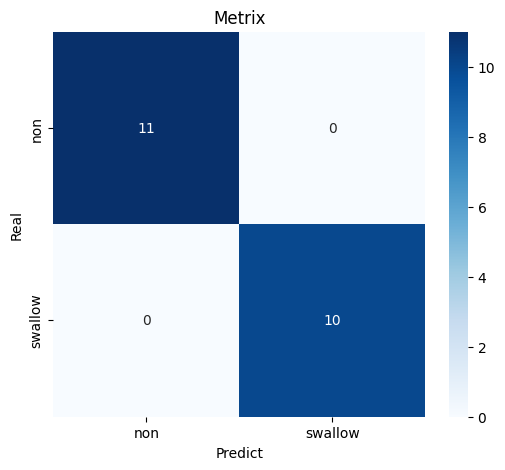

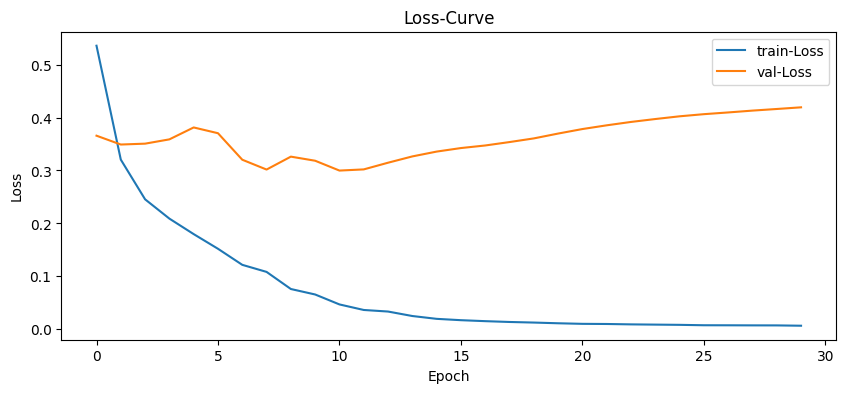

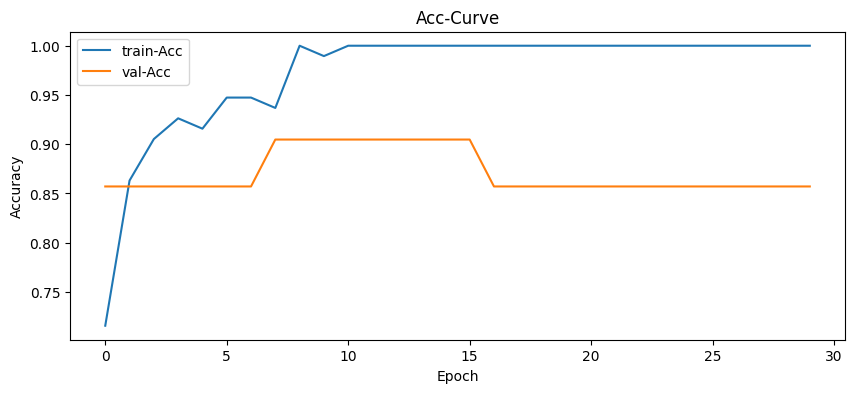

In [18]:
# 混淆矩陣

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non', 'swallow'], yticklabels=['non', 'swallow'])
plt.ylabel('Real')
plt.xlabel('Predict')
plt.title('Metrix')
plt.show()

# 繪製損失和準確率曲線

# 損失曲線
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='train-Loss')
plt.plot(val_losses, label='val-Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss-Curve')
plt.legend()
plt.show()

# 準確率曲線
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='train-Acc')
plt.plot(val_accuracies, label='val-Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Acc-Curve')
plt.legend()
plt.show()





In [19]:
MODEL_SAVE_PATH = 'model'

if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

model_file = os.path.join(MODEL_SAVE_PATH, 'audioModel.pth')
torch.save(model.state_dict(), model_file)

print(f"模型已保存到 {model_file}")


模型已保存到 model\audioModel.pth


In [20]:
# 如果需要，忽略警告
import warnings
warnings.filterwarnings('ignore')

# 設定裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [21]:
# 定義模型類並加載權重

class AudioClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, num_heads=4, num_layers=2, hidden_dim=128, dropout=0.1):
        super(AudioClassifier, self).__init__()
        self.input_dim = input_dim
        self.num_classes = num_classes
        
        # 定義位置編碼
        self.positional_encoding = nn.Parameter(torch.zeros(1, input_dim, hidden_dim))
        
        # 輸入線性層
        self.input_fc = nn.Linear(input_dim, hidden_dim)
        
        # Transformer 編碼器
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # 輸出層
        self.output_fc = nn.Linear(hidden_dim, num_classes)
        
        # 激活函數
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # x: [batch_size, input_dim]
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        x = self.input_fc(x) + self.positional_encoding[:, :x.size(1), :]
        x = x.permute(1, 0, 2)  # [seq_len, batch_size, hidden_dim]
        x = self.transformer_encoder(x)
        x = x[-1, :, :]  # [batch_size, hidden_dim]
        x = self.output_fc(self.relu(x))
        return x

# 加載模型權重
MODEL_SAVE_PATH = 'model'  # 請替換為您的實際路徑
model_file = os.path.join(MODEL_SAVE_PATH, 'audioModel.pth')

# 獲取輸入維度和類別數（需要與訓練時一致）
input_dim = X_train.shape[1]
print("輸入維度：", input_dim)
num_classes = 2  # 吞嚥和非吞嚥

# 初始化模型並加載權重
model = AudioClassifier(input_dim=input_dim, num_classes=num_classes)
model.load_state_dict(torch.load(model_file, map_location=device))
model.to(device)
model.eval()  # 設置為評估模式


輸入維度： 1984


AudioClassifier(
  (input_fc): Linear(in_features=1984, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_fc): Linear(in_features=128, out_features=2, bias=True)
  (relu): ReLU()
)

In [22]:
# 定義預處理函數

# 預處理參數（需與訓練時一致）
SAMPLE_RATE = 16000
SEGMENT_DURATION = 1.0
N_MELS = 64
N_FFT = 1024
HOP_LENGTH = 512
FIXED_DURATION = 1.0 # 秒
FIXED_LENGTH = int(SAMPLE_RATE * FIXED_DURATION)

def load_audio(file_path, sample_rate=SAMPLE_RATE):
    """
    加載音頻文件
    """
    audio, sr = librosa.load(file_path, sr=sample_rate)
    return audio, sr

def preprocess_audio(file_path):
    # 對單個音頻文件進行預處理
    # 加載音頻
    audio, sr = load_audio(file_path)
    
    # 確保音頻時長一致
    if len(audio) < FIXED_LENGTH:
        pad_width = FIXED_LENGTH - len(audio)
        audio = np.pad(audio, (0, pad_width), mode='constant')
    else:
        audio = audio[:FIXED_LENGTH]
    
    # 振幅正規化
    max_abs_amplitude = np.max(np.abs(audio))
    if max_abs_amplitude > 0:
        audio = audio / max_abs_amplitude
    
    # 降噪處理（可根據需要選擇是否應用）
    audio = reduce_noise(audio, sr)
    
    # 提取梅爾頻譜圖
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS
    )
    # 對數壓縮
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # 標準化特徵
    mean = np.mean(log_mel_spectrogram)
    std = np.std(log_mel_spectrogram)
    standardized_feature = (log_mel_spectrogram - mean) / std
    
    # 調整特徵形狀
    expected_shape = (N_MELS, int(np.ceil((FIXED_LENGTH - N_FFT) / HOP_LENGTH)) + 1)
    if standardized_feature.shape != expected_shape:
        # 填充或截斷
        if standardized_feature.shape[1] < expected_shape[1]:
            pad_width = expected_shape[1] - standardized_feature.shape[1]
            standardized_feature = np.pad(standardized_feature, ((0, 0), (0, pad_width)), mode='constant')
        elif standardized_feature.shape[1] > expected_shape[1]:
            standardized_feature = standardized_feature[:, :expected_shape[1]]
    
    # 展平成一維向量
    feature = standardized_feature.flatten()
    
    # 轉換為張量
    feature = torch.tensor(feature, dtype=torch.float32)
    
    return feature


In [23]:
def plot_mel_spectrogram(log_mel_spectrogram):
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(log_mel_spectrogram, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel')
        plt.tight_layout()
        plt.show()

In [24]:
# 批量測試多個音訊文件
TEST_AUDIO_DIR = 'data/swallow'  # 測試音訊文件夾
class_names=['non', 'swallow']
wantedPre = "swallow"

# 獲取所有音訊文件路徑
test_audio_files = [os.path.join(TEST_AUDIO_DIR, f) for f in os.listdir(TEST_AUDIO_DIR) if f.endswith('.wav')]

for audio_file in test_audio_files:
    print(f"正在處理文件：{audio_file}")
    # 預處理音訊文件
    feature = preprocess_audio(audio_file)
    feature = feature.to(device)
    feature = feature.unsqueeze(0)
    
    with torch.no_grad():
        outputs = model(feature)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.item()
    
    # standardized_feature = feature.cpu().numpy().reshape(N_MELS, -1)
    # mean = np.mean(standardized_feature)
    # std = np.std(standardized_feature)
    # log_mel_spectrogram = standardized_feature * std + mean  # 還原標準化
    # plot_mel_spectrogram(log_mel_spectrogram)
    if(class_names[predicted] != wantedPre):
        print("預測結果錯誤")
    print(f"模型預測結果：{class_names[predicted]}")
    print("-" * 30)


正在處理文件：data/swallow\01-swallow-2.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\01-swallow.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\02-swallow-2.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\02-swallow.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\03-swallow-2.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\03-swallow.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\04-swallow-2.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\04-swallow.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\05-swallow-2.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\05-swallow.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\06-swallow-2.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swallow\06-swallow.wav
模型預測結果：swallow
------------------------------
正在處理文件：data/swal

In [25]:
model_scripted = torch.jit.script(model)  # Export to TorchScript
model_scripted.save('model/model.pt')


In [44]:
model = torch.load("model/model.pt")
def detect_swallow_in_1s_segments(audio_path):
    # Load and preprocess the entire audio file
    audio, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    segment_length = int(SAMPLE_RATE *2.3)  # 2-second segments
    swallow_count = 0
    
    # Split audio into 2-second segments and process
    for i in range(0, len(audio), segment_length):
        audio_segment = audio[i:i + segment_length]
        if len(audio_segment) < segment_length:
            continue
        feature = preprocess_audio(audio_file)
        feature = feature.to(device)
        feature = feature.unsqueeze(0)

        # Model inference
        with torch.no_grad():
            outputs = model(feature)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)
            predicted = predicted.item()
            confidence = confidence.item()
            if(class_names[predicted] == "swallow"):
                swallow_count = swallow_count+1
                # print(f"Swallow detected in segment {i+1} with confidence {confidence:.2f}")

    print(f"檢測到的吞嚥次數：{swallow_count}")

# Example usage for a single audio file divided into 1-second segments
detect_swallow_in_1s_segments('音檔/在背景有噪音時 RSST.wav')

檢測到的吞嚥次數：6
